In [3]:
!pip install --quiet google-cloud-bigquery

# Import libraries
from google.cloud import bigquery
from google.colab import auth

# Authenticate your Google account
auth.authenticate_user()

# Set up BigQuery client (use your GCP project ID)
project_id = 'akashapiplayground'  # Replace with your actual project ID
client = bigquery.Client(project=project_id)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import plotly.graph_objects as go

In [5]:
query = """

  SELECT *
  FROM `physionet-data.mimiciii_clinical.admissions`
  """

query_job = client.query(query)
admissions = query_job.to_dataframe()
len(admissions)

58976

In [6]:
query = """

  SELECT *
  FROM `physionet-data.mimiciii_clinical.patients`
  """

query_job = client.query(query)
patients = query_job.to_dataframe()
len(patients)

46520

In [18]:
query = """

  SELECT *
  FROM `physionet-data.mimiciii_clinical.labevents`
  LIMIT 1000000
  """

query_job = client.query(query)
labevents = query_job.to_dataframe()
len(labevents)

1000000

In [8]:
query = """

  SELECT *
  FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
  """

query_job = client.query(query)
diagnoses_icd = query_job.to_dataframe()
len(diagnoses_icd)

651047

In [9]:
query = """

  SELECT *
  FROM `physionet-data.mimiciii_clinical.d_icd_diagnoses`
  """

query_job = client.query(query)
d_icd_diagnoses = query_job.to_dataframe()
len(d_icd_diagnoses)

14567

In [10]:
query = """

  SELECT *
  FROM `physionet-data.mimiciii_clinical.callout`
  """

query_job = client.query(query)
callout = query_job.to_dataframe()
len(callout)

34499

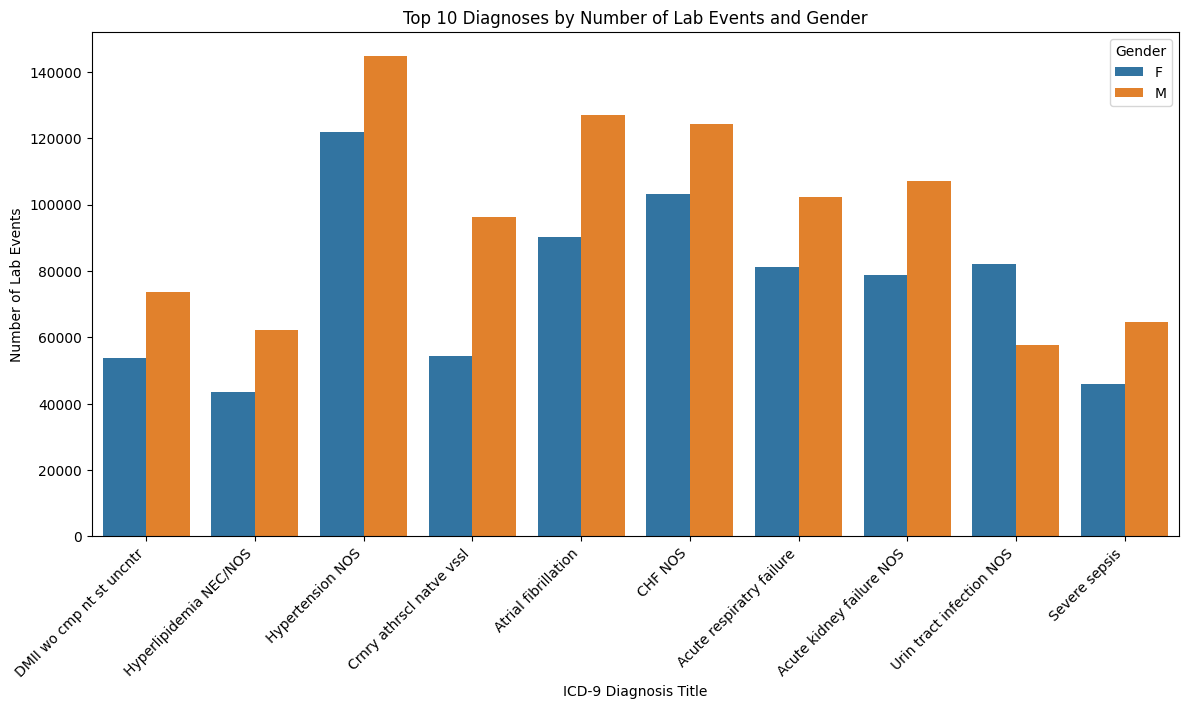

In [19]:
# Graph 1
# Motivation: Observe diseases which leads to most lab tests, and observe its distribution by gender
# From labevents, capture the diseases which leads to most labevents,

# Merge labevents with admissions to get disease icd_9 code
labs = labevents.merge(admissions[['SUBJECT_ID', 'HADM_ID']], on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Merge with diagnoses to get ICD codes
labs_diag = labs.merge(diagnoses_icd[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']],
                       on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Merge with patients to get gender
labs_diag = labs_diag.merge(patients[['SUBJECT_ID', 'GENDER']], on='SUBJECT_ID', how='left')

# Count lab events per icd9_code and Gender
lab_counts = labs_diag.groupby(['ICD9_CODE', 'GENDER']).size().reset_index(name='LABEVENT_COUNT')

# Select top diagnoses by total volume
top_codes = (lab_counts.groupby('ICD9_CODE')['LABEVENT_COUNT']
                        .sum()
                        .nlargest(10)
                        .index)

# Filter to just those
lab_counts_top = lab_counts[lab_counts['ICD9_CODE'].isin(top_codes)]

# Load icd9_code mapping
icd9_map = d_icd_diagnoses[['ICD9_CODE', 'SHORT_TITLE']]
lab_counts_top = lab_counts_top.merge(icd9_map, on='ICD9_CODE', how='left')


# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=lab_counts_top, x='SHORT_TITLE', y='LABEVENT_COUNT', hue='GENDER')
plt.title('Top 10 Diagnoses by Number of Lab Events')
plt.ylabel('Number of Lab Events')
plt.xlabel('ICD-9 Diagnosis Title')
plt.legend(title='Gender')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

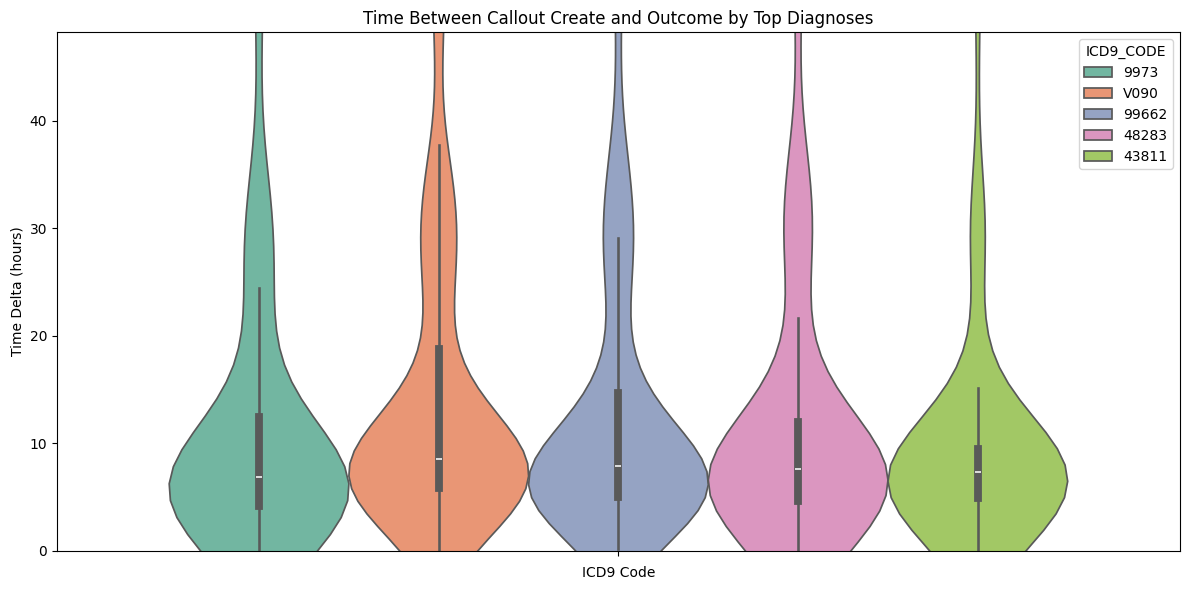

In [50]:
# Graph 2
# Motivation: which diagnosis leads to most dispersed/high variance delay in callout
# Time delta range between outcometime and createtime for callout table records
# based on diagnosis data available in admissions table

# Clean time columns
callout['CREATETIME'] = pd.to_datetime(callout['CREATETIME'])
callout['OUTCOMETIME'] = pd.to_datetime(callout['OUTCOMETIME'])

# Calculate time delta in hours
callout['DELAY_HOURS'] = (callout['OUTCOMETIME'] - callout['CREATETIME']).dt.total_seconds() / 3600
callout = callout[callout['DELAY_HOURS'] >= 0]  # remove negative delays

# Join with diagnoses
call_diag = callout.merge(diagnoses_icd[['HADM_ID', 'ICD9_CODE']], on='HADM_ID', how='left')

# Get top 500 frequent diagnoses
top_diagnoses = (call_diag['ICD9_CODE'].value_counts().nlargest(500).index)
call_diag_top = call_diag[call_diag['ICD9_CODE'].isin(top_diagnoses)]

# For each diagnosis, calculate variation in delay
varied_delay = call_diag_top.groupby('ICD9_CODE')['DELAY_HOURS'].var().sort_values(ascending=False)

# Take top 5 most dispersed diagnoses
top5_delayed = varied_delay.head(5).index
call_diag_top = call_diag_top[call_diag_top['ICD9_CODE'].isin(top5_delayed)]

# Plot violin
plt.figure(figsize=(12, 6))
sns.violinplot(data=call_diag_top, hue='ICD9_CODE', y='DELAY_HOURS', palette='Set2', inner='box', legend=True)
plt.title("Time Between Callout Create and Outcome by Top Diagnoses")
plt.xlabel("ICD9 Code")
plt.ylabel("Time Delta (hours)")
plt.ylim(0, call_diag_top['DELAY_HOURS'].quantile(0.95))  # cap outliers for readability
plt.tight_layout()
plt.show()

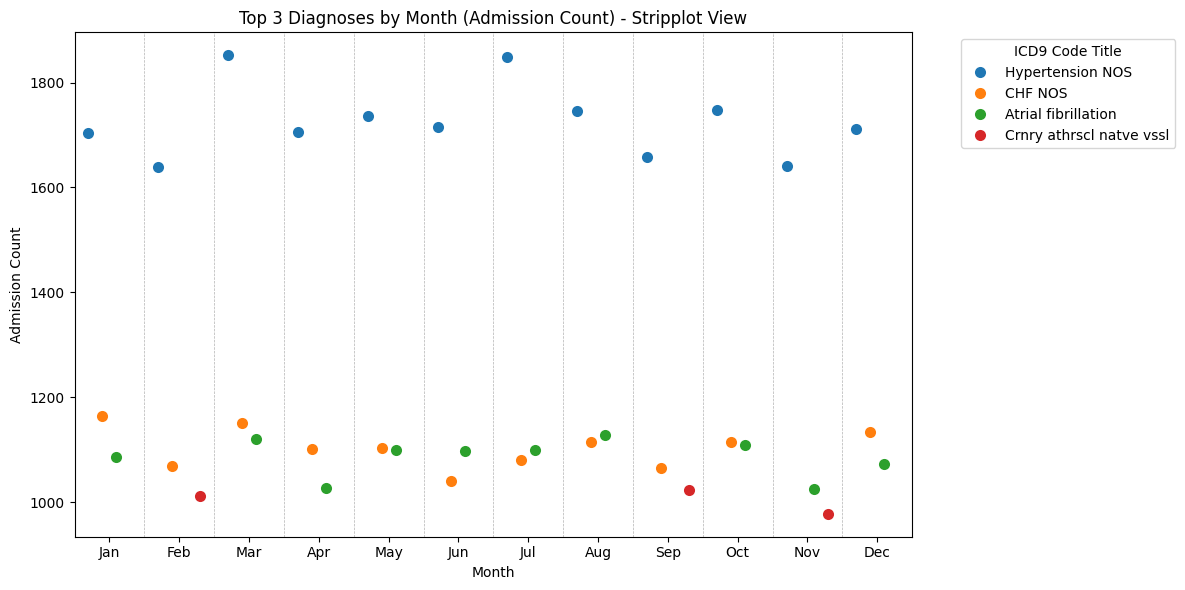

In [51]:
# Graph 3
# Motivation: Capture any potential pattern in diseases treated and the month they r treated in
# From admissions table, capture the top 3 diagnosis for each month and see for any emerging pattern

# Convert admittime to datetime and extract month
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['MONTH'] = admissions['ADMITTIME'].dt.month

# Join with diagnoses
adm_diag = admissions.merge(diagnoses_icd[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']],
                            on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Count diagnosis occurrences per month
monthly_diag_counts = (adm_diag.groupby(['MONTH', 'ICD9_CODE']).size().reset_index(name='COUNT'))

# For each month, get top 3 diagnoses
top3_by_month = (monthly_diag_counts.sort_values(['MONTH', 'COUNT'], ascending=[True, False])
                                     .groupby('MONTH').head(3))

# Map icd9_code to title
icd_map = d_icd_diagnoses[['ICD9_CODE', 'SHORT_TITLE']]
top3_by_month = top3_by_month.merge(icd_map, on='ICD9_CODE', how='left')

#  Map month to month names
month_order = list(calendar.month_abbr)[1:]  # Jan to Dec
top3_by_month['MONTH_NAME'] = top3_by_month['MONTH'].apply(lambda x: calendar.month_abbr[x])

# Plot with stripplot
plt.figure(figsize=(12, 6))
ax = sns.stripplot(data=top3_by_month, x='MONTH_NAME', y='COUNT', hue='SHORT_TITLE',
              jitter=True, size=8, palette='tab10', dodge=True)

for i in range(len(month_order) - 1):
    ax.axvline(i + 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

plt.title("Top 3 Diagnoses by Month (Admission Count) - Stripplot View")
plt.xlabel("Month")
plt.ylabel("Admission Count")
plt.legend(title='ICD9 Code Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipython-input-72-3282977467.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-72-3282977467.py:25: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



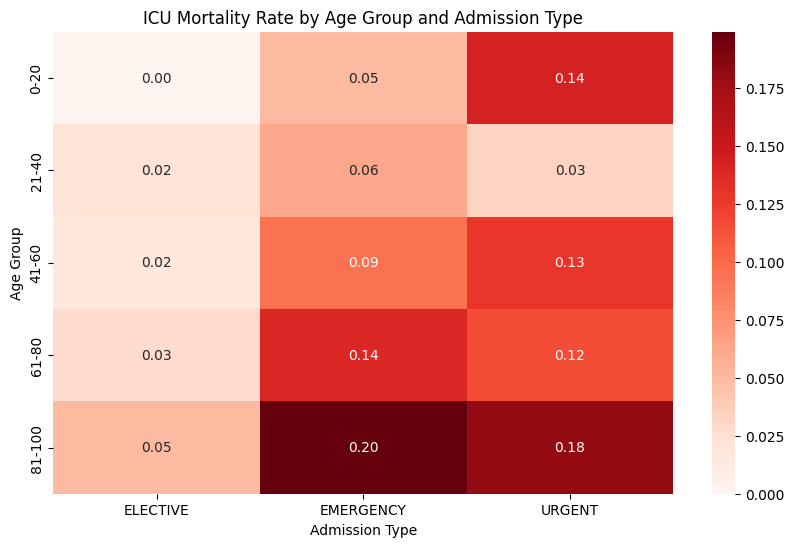

In [72]:
# Graph 4
# Motivation : Capture mortality rate across age and type of admission

# Preprocess age and group into bins
def calculate_age(dob, admittime):
    dob_date = datetime.strptime(str(dob), "%Y-%m-%d %H:%M:%S")
    admittime_date = datetime.strptime(str(admittime), "%Y-%m-%d %H:%M:%S")
    age = (admittime_date - dob_date).days // 365
    return age

# Merge to get DOB for each admission (many-to-one merge)
adm = admissions.merge(patients[['SUBJECT_ID', 'DOB']], on='SUBJECT_ID', how='left')

# Calculate age
adm['AGE'] = adm.apply(lambda row: calculate_age(row['DOB'], row['ADMITTIME']), axis=1)

# Cap unrealistic ages
adm = adm[adm['AGE'] < 100]

# Bucket age
adm['AGE_GROUP'] = pd.cut(adm['AGE'], bins=[0, 20, 40, 60, 80, 100],
                          labels=["0-20", "21-40", "41-60", "61-80", "81-100"])

# Pivot mortality rate by age group and admission type
heatmap_data = adm.pivot_table(
    index='AGE_GROUP',
    columns='ADMISSION_TYPE',
    values='HOSPITAL_EXPIRE_FLAG',
    aggfunc='mean'
)
heatmap_data = heatmap_data.astype(float)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Reds", fmt=".2f")
plt.title("ICU Mortality Rate by Age Group and Admission Type")
plt.ylabel("Age Group")
plt.xlabel("Admission Type")
plt.show()

In [73]:
# Graph 5
# Using plotly visualizes patient flow paths from admission type to outcome.

# Limit to random 1000 admission records
admissions_limited = admissions.sample(n=1000).reset_index(drop=True)

flows = admissions_limited.groupby(['ADMISSION_TYPE', 'INSURANCE', 'DISCHARGE_LOCATION']).size().reset_index(name='COUNT')

labels = list(set(flows['ADMISSION_TYPE']) | set(flows['INSURANCE']) | set(flows['DISCHARGE_LOCATION']))
label_map = {k: v for v, k in enumerate(labels)}

source = flows['ADMISSION_TYPE'].map(label_map)
intermediate = flows['INSURANCE'].map(label_map)
target = flows['DISCHARGE_LOCATION'].map(label_map)

# Split into 2 links: Admission → Insurance, Insurance → Discharge
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels),
    link=dict(
        source=source.tolist() + intermediate.tolist(),
        target=intermediate.tolist() + target.tolist(),
        value=flows['COUNT'].tolist() + flows['COUNT'].tolist()
    ))])

fig.update_layout(title_text="Patient Flow: Admission → Insurance → Discharge", font_size=10)
fig.show()